### 1. Load the dataset

**[1.1] Automatic reload modules**

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**[1.2] Import packages**

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

**[1.3] Load the datasets**

In [26]:
X_train = pd.read_csv('../data/processed/X_train.csv')
X_val   = pd.read_csv('../data/processed/X_val.csv')
X_test  = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
y_val   = pd.read_csv('../data/processed/y_val.csv')
y_test = pd.read_csv('../data/interim/y_test.csv')

### 2. Feature Engineering

* Based on feature importance done in the previous experiment, the least significant features will be excluded in this experiment.

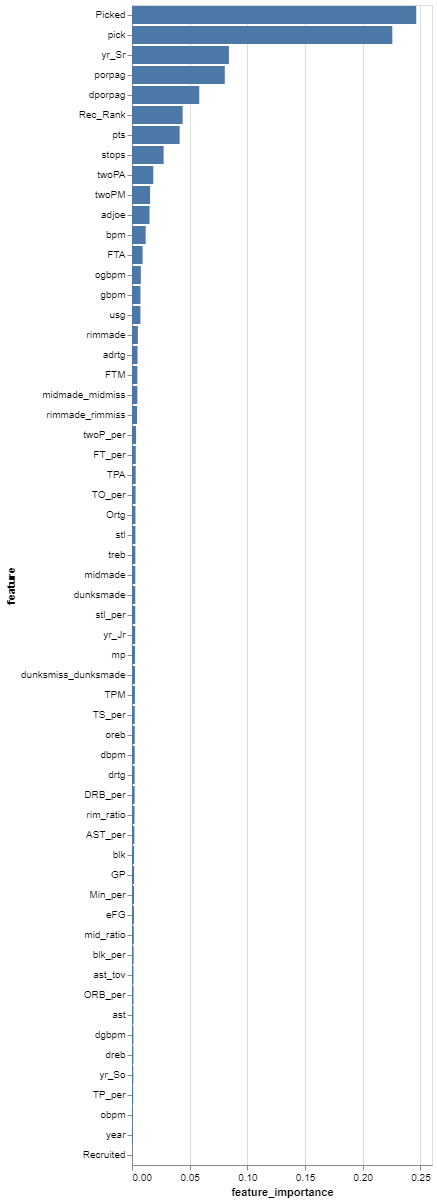

In [27]:
#list the features
X_train.columns

Index(['yr_Jr', 'yr_So', 'yr_Sr', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG',
       'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA',
       'FT_per', 'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per',
       'blk_per', 'stl_per', 'porpag', 'adjoe', 'year', 'Rec_Rank', 'ast_tov',
       'rimmade', 'rimmade_rimmiss', 'midmade', 'midmade_midmiss', 'rim_ratio',
       'mid_ratio', 'dunksmade', 'dunksmiss_dunksmade', 'pick', 'drtg',
       'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'mp',
       'ogbpm', 'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts',
       'Picked', 'Recruited'],
      dtype='object')

In [28]:
to_keep = ['Picked', 'pick', 'yr_Jr', 'yr_So', 'yr_Sr', 'porpag', 'dporpag', 
            'Rec_Rank', 'pts', 'stops', 'twoPM', 'twoPA', 'adjoe', 'bpm', 'FTA',
           'ogbpm', 'gbpm', 'usg', 'rimmade', 'adrtg', 'FTM', 'rimmade_rimmiss',
           'midmade_midmiss', 'twoP_per', 'FT_per', 'TPA', 'TO_per']

In [29]:
X_train = X_train[to_keep]
X_val = X_val[to_keep]
X_test = X_test[to_keep]

X_train.columns

Index(['Picked', 'pick', 'yr_Jr', 'yr_So', 'yr_Sr', 'porpag', 'dporpag',
       'Rec_Rank', 'pts', 'stops', 'twoPM', 'twoPA', 'adjoe', 'bpm', 'FTA',
       'ogbpm', 'gbpm', 'usg', 'rimmade', 'adrtg', 'FTM', 'rimmade_rimmiss',
       'midmade_midmiss', 'twoP_per', 'FT_per', 'TPA', 'TO_per'],
      dtype='object')

In [30]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(33001, 27)
(8251, 27)
(4970, 27)


In [31]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()

### 3. Train RandomForest - Hyperparameter Tuning with RandomSearchCV

**[3.1] Instantiate and fit the model**

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=8)

**[3.2] Parameters dictionary**

In [33]:
from scipy.stats import randint

param_ran = {
    'n_estimators': randint(5, 50),
    'max_depth': randint(5, 30),
    'min_samples_leaf': randint(10, 50),
    'max_features': randint(2, 20)
}

**[3.3] Instantiate and fit the hyperparameters wit Stratified KFold**

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)
ransearch = RandomizedSearchCV(rf, param_ran, cv=skf, random_state=8)

In [35]:
ransearch.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8, shuffle=True),
                   estimator=RandomForestClassifier(random_state=8),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B4CFDB67D0>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B4CFE117D0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B4CFE11CD0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B4CFE12350>},
                   random_state=8)

**[3.4] Display the best set of parameters**

In [36]:
ransearch.best_params_

{'max_depth': 8,
 'max_features': 19,
 'min_samples_leaf': 15,
 'n_estimators': 31}

**[3.5] Evaluation metrics for hyperparameters**

In [37]:
ransearch.best_score_

np.float64(0.99560617996355)

In [38]:
print("RanCV_Train:", f'{ransearch.score(X_train, y_train):.4f}')
print("RanCV_val:", f'{ransearch.score(X_val, y_val):.4f}')

RanCV_Train: 0.9972
RanCV_val: 0.9962


**[3.6] Make prediction on training data**

In [39]:
y_train_pred = ransearch.best_estimator_.predict_proba(X_train)[:, 1]
y_val_pred = ransearch.best_estimator_.predict_proba(X_val)[:, 1]

**[3.7] Performance metric - AUROC**

In [40]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [41]:
print("Train - AUROC:\n", f'{roc_auc_score(y_train, y_train_pred):.4f}')
print("Val - AUROC:\n", f'{roc_auc_score(y_val, y_val_pred):.4f}')

Train - AUROC:
 0.9993
Val - AUROC:
 0.9986


**Plot the AUROC curve**

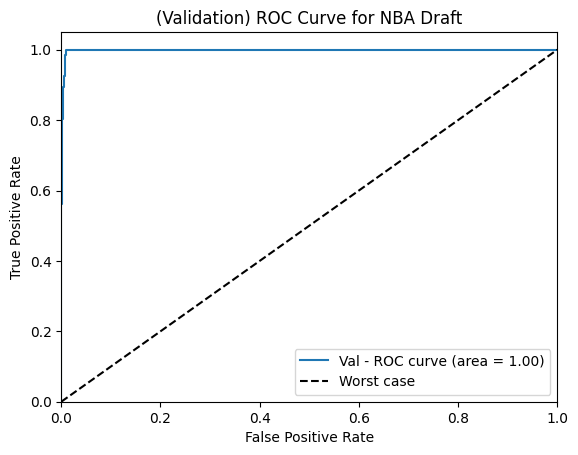

In [42]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred) 
roc_auc = auc(fpr, tpr)
plt.figure()  
plt.plot(fpr, tpr, label='Val - ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Worst case')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(Validation) ROC Curve for NBA Draft')
plt.legend()
plt.show()

**[3.8] Predict on test data**

In [43]:
y_test_pred = ransearch.best_estimator_.predict_proba(X_test)[:, 1]

#Dataframe for pred result
y_pred = y_test
y_pred.loc[:, 'drafted'] = y_test_pred

print(y_pred.describe().round(5))

y_pred = pd.DataFrame(y_pred)

#Save the result to CSV file
y_pred.to_csv('../data/external/at1_pred_week2.2.csv', index=False)

          drafted
count  4970.00000
mean      0.00410
std       0.04871
min       0.00000
25%       0.00000
50%       0.00000
75%       0.00000
max       0.93861


### 7. Feature Importance

In [44]:
feature = ransearch.best_estimator_.feature_importances_

In [45]:
#Dataframe of feature importance
feat_imp_rf_df = pd.DataFrame(
    {'feature': X_train.columns,
     'feature_importance': feature})

In [46]:
#Sort the dataframe
feat_imp_rf_df = feat_imp_rf_df.sort_values('feature_importance', ascending=False).reset_index(drop=True)
feat_imp_rf_df

,feature,feature_importance
0,Picked,0.295525
1,pick,0.195522
2,yr_Sr,0.123416
3,pts,0.089161
4,Rec_Rank,0.052897
5,dporpag,0.049097
6,porpag,0.046220
7,stops,0.025359
8,adjoe,0.016423
9,twoPA,0.016282
